In [2]:
from pprint import pprint
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()

import tensorflow_probability as tfp

sns.reset_defaults()
sns.set_context(context='talk',font_scale=0.7)
plt.rcParams['image.cmap'] = 'viridis'

%matplotlib inline

tfd = tfp.distributions
tfb = tfp.bijectors

- ## Modeling

- ## Inference

- ## Criticism

# Plot 1000 samples from Standard Normal

In [4]:
normal = tfd.Normal(loc=0., scale=1.)
samples = normal.sample(1000)

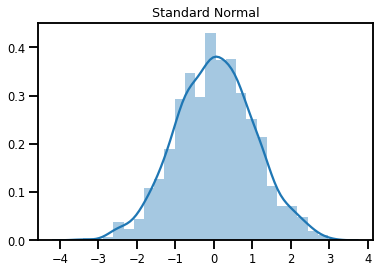

In [6]:
sns.distplot(samples)
plt.title('Standard Normal')
plt.show()

In [8]:
normal.log_prob(0.)

<tf.Tensor: shape=(), dtype=float32, numpy=-0.9189385>

In [16]:
normals = tfd.Normal(0., [2., 1., 3.])

In [17]:
samples = normals.sample(1000)

In [18]:
samples.shape

TensorShape([1000, 3])

<AxesSubplot:>

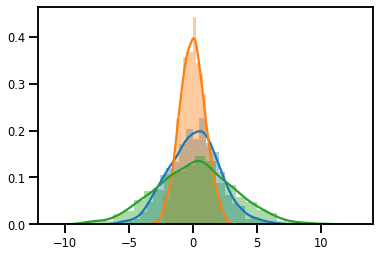

In [20]:
sns.distplot(samples[:, 0])
sns.distplot(samples[:, 1])
sns.distplot(samples[:, 2])

In [21]:
normals.log_prob([10., 10., 10.])

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([-14.112085 , -50.918938 ,  -7.5731063], dtype=float32)>

In [22]:
normals.log_prob(0.)

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([-1.6120857, -0.9189385, -2.017551 ], dtype=float32)>

# Multi-variate Distributions

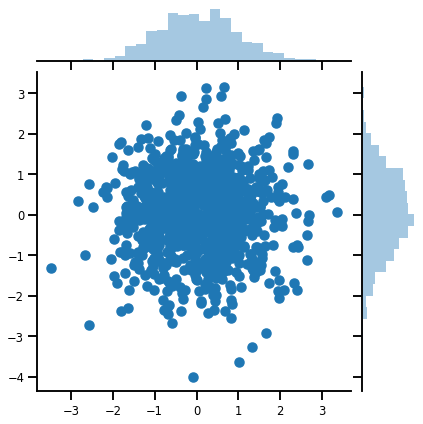

In [23]:
mvn = tfd.MultivariateNormalDiag(loc=[0., 0.], scale_diag = [1., 1.])
samples = mvn.sample(1000)
sns.jointplot(samples[:, 0], samples[:, 1], kind='scatter')

**Event Shape**

In [28]:
mvn.event_shape, mvn.batch_shape

(TensorShape([2]), TensorShape([]))

# A Simple Bijector

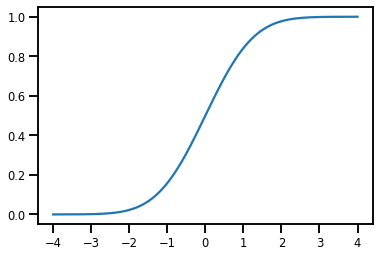

In [29]:
normal_cdf = tfb.NormalCDF()
xs = np.linspace(-4, 4, 200)
plt.plot(xs, normal_cdf.forward(xs))

In [30]:
cdf_samples = normal_cdf.forward(xs)

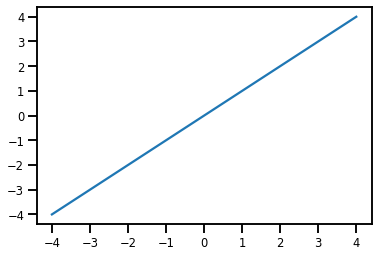

In [31]:
plt.plot(xs, normal_cdf.inverse(cdf_samples))

# MCMC

In [32]:
# Generate some data
def f(x, w):
  # Pad x with 1's so we can add bias via matmul
  x = tf.pad(x, [[1, 0], [0, 0]], constant_values=1)
  linop = tf.linalg.LinearOperatorFullMatrix(w[..., np.newaxis])
  result = linop.matmul(x, adjoint=True)
  return result[..., 0, :]

num_features = 2
num_examples = 50
noise_scale = .5
true_w = np.array([-1., 2., 3.])

xs = np.random.uniform(-1., 1., [num_features, num_examples])
ys = f(xs, true_w) + np.random.normal(0., noise_scale, size=num_examples)

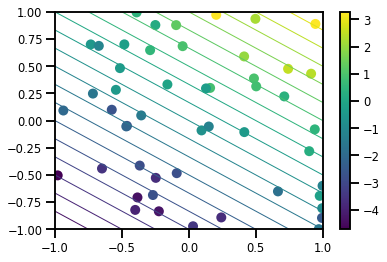

In [33]:
# Visualize the data set
plt.scatter(*xs, c=ys, s=100, linewidths=0)

grid = np.meshgrid(*([np.linspace(-1, 1, 100)] * 2))
xs_grid = np.stack(grid, axis=0)
fs_grid = f(xs_grid.reshape([num_features, -1]), true_w)
fs_grid = np.reshape(fs_grid, [100, 100])
plt.colorbar()
plt.contour(xs_grid[0, ...], xs_grid[1, ...], fs_grid, 20, linewidths=1)
plt.show()

In [37]:
# Define the joint_log_prob function, and our unnormalized posterior.
def joint_log_prob(w, x, y):
  # Our model in maths is
  #   w ~ MVN([0, 0, 0], diag([1, 1, 1]))
  #   y_i ~ Normal(w @ x_i, noise_scale),  i=1..N

  rv_w = tfd.Multivaria# Define the joint_log_prob function, and our unnormalized posterior.
def joint_log_prob(w, x, y):
  # Our model in maths is
  #   w ~ MVN([0, 0, 0], diag([1, 1, 1]))
  #   y_i ~ Normal(w @ x_i, noise_scale),  i=1..N

  rv_w = tfd.MultivariateNormalDiag(
    loc=np.zeros(num_features + 1),
    scale_diag=np.ones(num_features + 1))

  rv_y = tfd.Normal(f(x, w), noise_scale)
  return (rv_w.log_prob(w) +
          tf.reduce_sum(rv_y.log_prob(y), axis=-1))

In [38]:
# Create our unnormalized target density by currying x and y from the joint.
def unnormalized_posterior(w):
  return joint_log_prob(w, xs, ys)

In [39]:
# Create an HMC TransitionKernel
hmc_kernel = tfp.mcmc.HamiltonianMonteCarlo(
  target_log_prob_fn=unnormalized_posterior,
  step_size=np.float64(.1),
  num_leapfrog_steps=2)

In [40]:
# We wrap sample_chain in tf.function, telling TF to precompile a reusable
# computation graph, which will dramatically improve performance.
@tf.function
def run_chain(initial_state, num_results=1000, num_burnin_steps=500):
  return tfp.mcmc.sample_chain(
    num_results=num_results,
    num_burnin_steps=num_burnin_steps,
    current_state=initial_state,
    kernel=hmc_kernel,
    trace_fn=lambda current_state, kernel_results: kernel_results)

In [41]:
initial_state = np.zeros(num_features + 1)
samples, kernel_results = run_chain(initial_state)
print("Acceptance rate:", kernel_results.is_accepted.numpy().mean())

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
Acceptance rate: 0.897
